In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
dictionary={
    'Chembarambaakam':0,
    'Chozhavaram':1,
    'Poondi':2,
    'RedHills':3
}
revdict={
   
    0:'Chembarambaakam',
    1:'Chozhavaram',
    2:'Poondi',
    3:'RedHills'
}

dataset=[]
    
dataset.append(pd.read_csv(r'C:\Users\user\Desktop\DMTproj\dataset2\CHdianna.csv'))
dataset.append(pd.read_csv(r'C:\Users\user\Desktop\DMTproj\dataset2\CZdianna.csv'))
dataset.append(pd.read_csv(r'C:\Users\user\Desktop\DMTproj\dataset2\PNdianna.csv'))
dataset.append(pd.read_csv(r'C:\Users\user\Desktop\DMTproj\dataset2\RHdianna.csv'))

for i in range(0,4):
    print('\n',revdict[i],':\n')
    dataset[i]=dataset[i].dropna()
    print(dataset[i].tail())


 Chembarambaakam :

            Date  nth day in year  Storage (mcft)  Inflow (cusecs)  \
5109  27/12/2017              360          1863.0              0.0   
5110  28/12/2017              361          1859.0              0.0   
5111  29/12/2017              362          1855.0              0.0   
5112  30/12/2017              363          1851.0              0.0   
5113  31/12/2017              364          1847.0              0.0   

      Rainfall (mm)  Outflow (cusecs)  
5109            0.0                49  
5110            0.0                49  
5111            0.0                49  
5112            0.0                49  
5113            0.0                49  

 Chozhavaram :

            Date  nth day in year  Storage (mcft)  Inflow (cusecs)  \
5109  27/12/2017              360           528.0              0.0   
5110  28/12/2017              361           525.0              0.0   
5111  29/12/2017              362           522.0              0.0   
5112  30/12/2017     

In [3]:
def drop_columns(data):
    siro=data.drop(columns=['Date','nth day in year'])
    '''for i in ['Storage (mcft)', 'Inflow (cusecs)','Rainfall (mm)','Outflow (cusecs)']:
    siro[i]-=min(galactus[i])
    siro[i]/=(max(galactus[i])-min(galactus[i]))'''
    return siro

def sequence_prepare(raw,lookback=5):
    shape=((len(raw)-lookback),lookback,raw.shape[-1])
    sequence=np.zeros(shape)
    target=np.zeros(len(raw)-lookback)

    for i in range(lookback, len(raw)):
        for j in range(0,lookback):
              sequence[i-lookback][j]=raw.loc[i+j-lookback,:]
        target[i-lookback]=raw['Outflow (cusecs)'][i]

    return sequence,target



In [5]:
siro=[]
target=[]
for i in range(0,4):
    x=drop_columns(dataset[i])
    x,y=sequence_prepare(x)
    siro.append(x)
    target.append(y)


    

In [6]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

from sklearn.model_selection import train_test_split

for i in range(0,4):
    Xtrain, Xtest, ytrain, ytest = train_test_split( siro[i], target[i], test_size=0.2, random_state=0)
    x_train.append(Xtrain)
    y_train.append(ytrain)
    x_test.append(Xtest)
    y_test.append(ytest)

print(x_train[0].shape)
print(x_test[0].shape)


(4087, 5, 4)
(1022, 5, 4)


In [ ]:
#model LSTM
from tensorflow.keras import layers
xin=[]
xout=[]
lstm=[]
lookback=5
for i in range(0,4):
    xin.append(layers.Input(shape=(lookback,4),name=('Input'+str(i+1))))
    lstm.append(layers.LSTM(32,dropout=0.1,recurrent_dropout=0.5,activation='tanh',return_sequences=True,name=('LSTM'+str(i+1)))(xin[i]))
    lay1= layers.Dense(16, activation='relu')(lstm[i])
    flat=layers.Flatten()(lay1)
    xout.append(layers.Dense(1,activation='relu',name=('output'+str(i+1)))(flat))  

In [ ]:
from tensorflow.keras import models
from keras.optimizers import Adam, RMSprop
all_models=[]
for i in range(0,4):
    
    model=models.Model(inputs=xin[i],outputs=xout[i])
    model.compile(loss='mae', optimizer='rmsprop',metrics=["mae", "mse"])
    all_models.append(model)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0.3,patience = 10, verbose = 1)
#earlystop=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=6,restore_best_weights=False)
model_history=[]
fitted_models=[]
for i in range(0,4):
    history = all_models[i].fit(x_train[i], y_train[i],epochs=100,batch_size=128,validation_split=0.2,verbose=1)
    model_history.append(history)
    fitted_models.append(model)
    


In [ ]:
import matplotlib.pyplot as plt
for i in range(0,4):
    plt.plot(model_history[i].history['loss'])
    plt.plot(model_history[i].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
predictions=[]
for i in range(0,4):
    predictions.append(fitted_models[i].predict(x_test[i]))

    
x=[]
for i in range(0,1022):
    x.append(i)
    
for i in range(0,4):
    plt.figure(figsize=(20,12))
    plt.plot(x,y_test[0], color= "red",label="original")
    plt.plot(x, predictions[0], color = "green",label="prediction")
    plt.title('\n',revdict[i],':\n')
    plt.xlabel("days")
    plt.ylabel("Outflow")
    plt.show()
    

In [ ]:
#model CNN
from keras.layers import Conv2D, MaxPooling1D, Concatenate, Activation, Dropout, Flatten, Dense
from tensorflow.keras import layers
xin=[]
xout=[]
lookback=5

for i in range(0,4):
    xin.append(layers.Input(shape=(lookback,4),name=('Input'+str(i+1))))
    lay1=layers.Conv1D(32,1,activation='relu')(xin[i])
    pool1=layers.MaxPooling1D(pool_size=2,strides=1)(lay1)
    lay2=layers.Conv1D(64,1,activation='relu')(pool1)
    pool2=layers.MaxPooling1D(pool_size=2,strides=1)(lay2)
    
    dense1= layers.Dense(64, activation='relu')(pool2)
    dense2= layers.Dense(128, activation='relu')(dense1)
    flat=layers.Flatten()(dense2)
    xout.append(layers.Dense(1,activation='relu',name=('output'+str(i+1)))(flat)) 

In [79]:
#model LSTM+CNN
from keras.layers import Conv2D, MaxPooling1D, Concatenate, Activation, Dropout, Flatten, Dense
from tensorflow.keras import layers
# Creating Model

xin=[]
lstm=[]
cnn_raw=[]
cnn=[]
x=[]
xout=[]
xd=[]
lookback=5
for i in range(0,4):
    xin.append(layers.Input(shape=(lookback,4),name=('Input'+str(i+1))))
    lstm.append(layers.LSTM(32,dropout=0.1,recurrent_dropout=0.5,activation='relu',return_sequences=True,name=('LSTM'+str(i+1)))(xin[i]))
    
    lay1= layers.Conv1D(32,1,activation='relu')(xin[i])
    con=  layers.Concatenate(name=('C-Cat'+str(i)))([lstm[i], lay1])
    
    lay2= layers.Dense(16, activation='relu')(con)
    lay3= layers.Dense(32, activation='relu')(lay2)
    flat=layers.Flatten()(lay2)
    xout.append(layers.Dense(1,activation='relu',name=('output'+str(i+1)))(flat))                                               
    



In [59]:
from tensorflow.keras import models
from keras.optimizers import Adam, RMSprop
all_models=[]
for i in range(0,4):
    
    model=models.Model(inputs=xin[i],outputs=xout[i])
    model.compile(loss='mae', optimizer='rmsprop',metrics=["mae", "acc"])
    all_models.append(model)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0.3,patience = 10, verbose = 1)
#earlystop=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=6,restore_best_weights=False)
model_history=[]
fitted_models=[]
for i in range(0,4):
    history = all_models[i].fit(x_train[i], y_train[i],epochs=100,batch_size=128,validation_split=0.2,verbose=1)
    model_history.append(history)
    fitted_models.append(model)
    


Epoch 1/100
26/26 [==============================] - 1s 29ms/step - loss: 63.8253 - mae: 63.8253 - acc: 0.0728 - val_loss: 120.6775 - val_mae: 120.6775 - val_acc: 0.0782
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 52.5901 - mae: 52.5901 - acc: 0.0765 - val_loss: 124.9838 - val_mae: 124.9838 - val_acc: 0.0966
Epoch 3/100
26/26 [==============================] - 0s 8ms/step - loss: 48.9365 - mae: 48.9365 - acc: 0.0814 - val_loss: 124.3412 - val_mae: 124.3412 - val_acc: 0.1198
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 47.4580 - mae: 47.4580 - acc: 0.0850 - val_loss: 117.5268 - val_mae: 117.5268 - val_acc: 0.1064
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 45.3987 - mae: 45.3987 - acc: 0.0805 - val_loss: 117.0977 - val_mae: 117.0977 - val_acc: 0.1137
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 44.1718 - mae: 44.1718 - acc: 0.0860 - val_loss: 111.3041 - val_mae: 111.3041 - v

26/26 [==============================] - 0s 6ms/step - loss: 29.4444 - mae: 29.4444 - acc: 0.1205 - val_loss: 96.4608 - val_mae: 96.4608 - val_acc: 0.1222
Epoch 50/100
26/26 [==============================] - 0s 6ms/step - loss: 31.1651 - mae: 31.1651 - acc: 0.1221 - val_loss: 99.9767 - val_mae: 99.9767 - val_acc: 0.1222
Epoch 51/100
26/26 [==============================] - 0s 6ms/step - loss: 31.1231 - mae: 31.1231 - acc: 0.1196 - val_loss: 102.3735 - val_mae: 102.3735 - val_acc: 0.1015
Epoch 52/100
26/26 [==============================] - 0s 6ms/step - loss: 29.6734 - mae: 29.6734 - acc: 0.1205 - val_loss: 97.3506 - val_mae: 97.3506 - val_acc: 0.1235
Epoch 53/100
26/26 [==============================] - 0s 6ms/step - loss: 30.7668 - mae: 30.7668 - acc: 0.1224 - val_loss: 99.8486 - val_mae: 99.8486 - val_acc: 0.0978
Epoch 54/100
26/26 [==============================] - 0s 6ms/step - loss: 30.7097 - mae: 30.7097 - acc: 0.1190 - val_loss: 97.8818 - val_mae: 97.8818 - val_acc: 0.1222
Epo

Epoch 98/100
26/26 [==============================] - 0s 6ms/step - loss: 27.0427 - mae: 27.0427 - acc: 0.1245 - val_loss: 96.9831 - val_mae: 96.9831 - val_acc: 0.1161
Epoch 99/100
26/26 [==============================] - 0s 6ms/step - loss: 27.8367 - mae: 27.8367 - acc: 0.1230 - val_loss: 98.2379 - val_mae: 98.2379 - val_acc: 0.1161
Epoch 100/100
26/26 [==============================] - 0s 6ms/step - loss: 26.3654 - mae: 26.3654 - acc: 0.1221 - val_loss: 94.6075 - val_mae: 94.6075 - val_acc: 0.1235
Epoch 1/100
26/26 [==============================] - 1s 23ms/step - loss: 19.7905 - mae: 19.7905 - acc: 0.7577 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 2/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 

26/26 [==============================] - 0s 5ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 47/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 48/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 49/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 50/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 51/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch

Epoch 95/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 96/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 97/100
26/26 [==============================] - 0s 5ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 98/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 99/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc: 0.7665
Epoch 100/100
26/26 [==============================] - 0s 6ms/step - loss: 19.7901 - mae: 19.7901 - acc: 0.7580 - val_loss: 22.6675 - val_mae: 22.6675 - val_acc

26/26 [==============================] - 0s 6ms/step - loss: 78.2143 - mae: 78.2143 - acc: 0.2114 - val_loss: 139.8085 - val_mae: 139.8085 - val_acc: 0.2518
Epoch 44/100
26/26 [==============================] - 0s 6ms/step - loss: 77.6260 - mae: 77.6260 - acc: 0.2294 - val_loss: 158.9722 - val_mae: 158.9722 - val_acc: 0.2482
Epoch 45/100
26/26 [==============================] - 0s 6ms/step - loss: 75.0183 - mae: 75.0183 - acc: 0.2120 - val_loss: 140.9929 - val_mae: 140.9929 - val_acc: 0.2531
Epoch 46/100
26/26 [==============================] - 0s 7ms/step - loss: 78.8392 - mae: 78.8392 - acc: 0.2279 - val_loss: 144.6096 - val_mae: 144.6096 - val_acc: 0.2518
Epoch 47/100
26/26 [==============================] - 0s 7ms/step - loss: 75.3854 - mae: 75.3854 - acc: 0.2181 - val_loss: 136.9647 - val_mae: 136.9647 - val_acc: 0.2531
Epoch 48/100
26/26 [==============================] - 0s 6ms/step - loss: 74.4204 - mae: 74.4204 - acc: 0.2380 - val_loss: 152.6567 - val_mae: 152.6567 - val_acc: 

26/26 [==============================] - 0s 7ms/step - loss: 68.3270 - mae: 68.3270 - acc: 0.2472 - val_loss: 139.4204 - val_mae: 139.4204 - val_acc: 0.2494
Epoch 92/100
26/26 [==============================] - 0s 6ms/step - loss: 67.6168 - mae: 67.6168 - acc: 0.2331 - val_loss: 139.2136 - val_mae: 139.2136 - val_acc: 0.2494
Epoch 93/100
26/26 [==============================] - 0s 6ms/step - loss: 69.4527 - mae: 69.4527 - acc: 0.2407 - val_loss: 135.9328 - val_mae: 135.9328 - val_acc: 0.2482
Epoch 94/100
26/26 [==============================] - 0s 6ms/step - loss: 68.6388 - mae: 68.6388 - acc: 0.2389 - val_loss: 131.2679 - val_mae: 131.2679 - val_acc: 0.2555
Epoch 95/100
26/26 [==============================] - 0s 6ms/step - loss: 66.5235 - mae: 66.5235 - acc: 0.2349 - val_loss: 138.5125 - val_mae: 138.5125 - val_acc: 0.2311
Epoch 96/100
26/26 [==============================] - 0s 6ms/step - loss: 67.0566 - mae: 67.0566 - acc: 0.2401 - val_loss: 133.1738 - val_mae: 133.1738 - val_acc: 

Epoch 40/100
26/26 [==============================] - 0s 6ms/step - loss: 22.6931 - mae: 22.6931 - acc: 0.0226 - val_loss: 34.9319 - val_mae: 34.9319 - val_acc: 0.0220
Epoch 41/100
26/26 [==============================] - 0s 6ms/step - loss: 22.7636 - mae: 22.7636 - acc: 0.0226 - val_loss: 27.9655 - val_mae: 27.9655 - val_acc: 0.0171
Epoch 42/100
26/26 [==============================] - 0s 6ms/step - loss: 22.2931 - mae: 22.2931 - acc: 0.0232 - val_loss: 33.7864 - val_mae: 33.7864 - val_acc: 0.0220
Epoch 43/100
26/26 [==============================] - 0s 9ms/step - loss: 21.9404 - mae: 21.9404 - acc: 0.0229 - val_loss: 36.3707 - val_mae: 36.3707 - val_acc: 0.0232
Epoch 44/100
26/26 [==============================] - 0s 8ms/step - loss: 22.0158 - mae: 22.0158 - acc: 0.0229 - val_loss: 27.6782 - val_mae: 27.6782 - val_acc: 0.0171
Epoch 45/100
26/26 [==============================] - 0s 8ms/step - loss: 21.4902 - mae: 21.4902 - acc: 0.0242 - val_loss: 28.8343 - val_mae: 28.8343 - val_acc:

Epoch 89/100
26/26 [==============================] - 0s 6ms/step - loss: 18.1405 - mae: 18.1405 - acc: 0.0242 - val_loss: 24.7232 - val_mae: 24.7232 - val_acc: 0.0220
Epoch 90/100
26/26 [==============================] - 0s 6ms/step - loss: 17.4826 - mae: 17.4826 - acc: 0.0239 - val_loss: 29.6335 - val_mae: 29.6335 - val_acc: 0.0220
Epoch 91/100
26/26 [==============================] - 0s 6ms/step - loss: 18.1423 - mae: 18.1423 - acc: 0.0242 - val_loss: 31.5269 - val_mae: 31.5269 - val_acc: 0.0220
Epoch 92/100
26/26 [==============================] - 0s 6ms/step - loss: 17.6466 - mae: 17.6466 - acc: 0.0239 - val_loss: 32.9562 - val_mae: 32.9562 - val_acc: 0.0220
Epoch 93/100
26/26 [==============================] - 0s 6ms/step - loss: 17.6234 - mae: 17.6234 - acc: 0.0245 - val_loss: 31.0331 - val_mae: 31.0331 - val_acc: 0.0220
Epoch 94/100
26/26 [==============================] - 0s 6ms/step - loss: 17.6715 - mae: 17.6715 - acc: 0.0248 - val_loss: 32.8267 - val_mae: 32.8267 - val_acc:

In [86]:


'''import matplotlib.pyplot as plt
for i in range(0,4):
    plt.figure(figsize=(8,8))
    plt.plot(model_history[i].history['out'+str(i+1)+'_loss'])
    plt.plot(model_history[i].history['val_out'+str(i+1)+'_loss'])
    plt.title(revdict[i]+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.show()'''

"import matplotlib.pyplot as plt\nfor i in range(0,4):\n    plt.figure(figsize=(8,8))\n    plt.plot(model_history[i].history['out'+str(i+1)+'_loss'])\n    plt.plot(model_history[i].history['val_out'+str(i+1)+'_loss'])\n    plt.title(revdict[i]+' model loss')\n    plt.ylabel('loss')\n    plt.xlabel('epoch')\n    plt.legend(['loss', 'val_loss'], loc='upper right')\n    plt.show()"

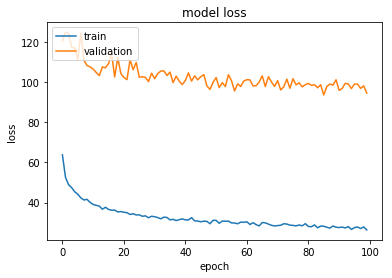

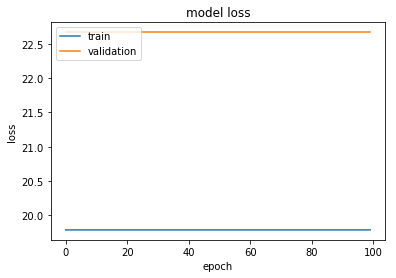

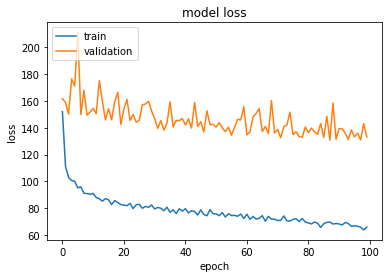

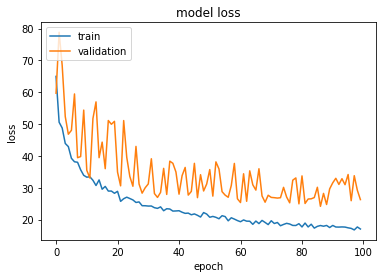

In [61]:
import matplotlib.pyplot as plt
for i in range(0,4):
    plt.plot(model_history[i].history['loss'])
    plt.plot(model_history[i].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [63]:
predictions=[]
for i in range(0,4):
    predictions.append(fitted_models[i].predict(x_test[i]))

predictions[0]

array([[ 0.      ],
       [22.93996 ],
       [99.79405 ],
       ...,
       [ 0.      ],
       [51.896976],
       [78.87875 ]], dtype=float32)

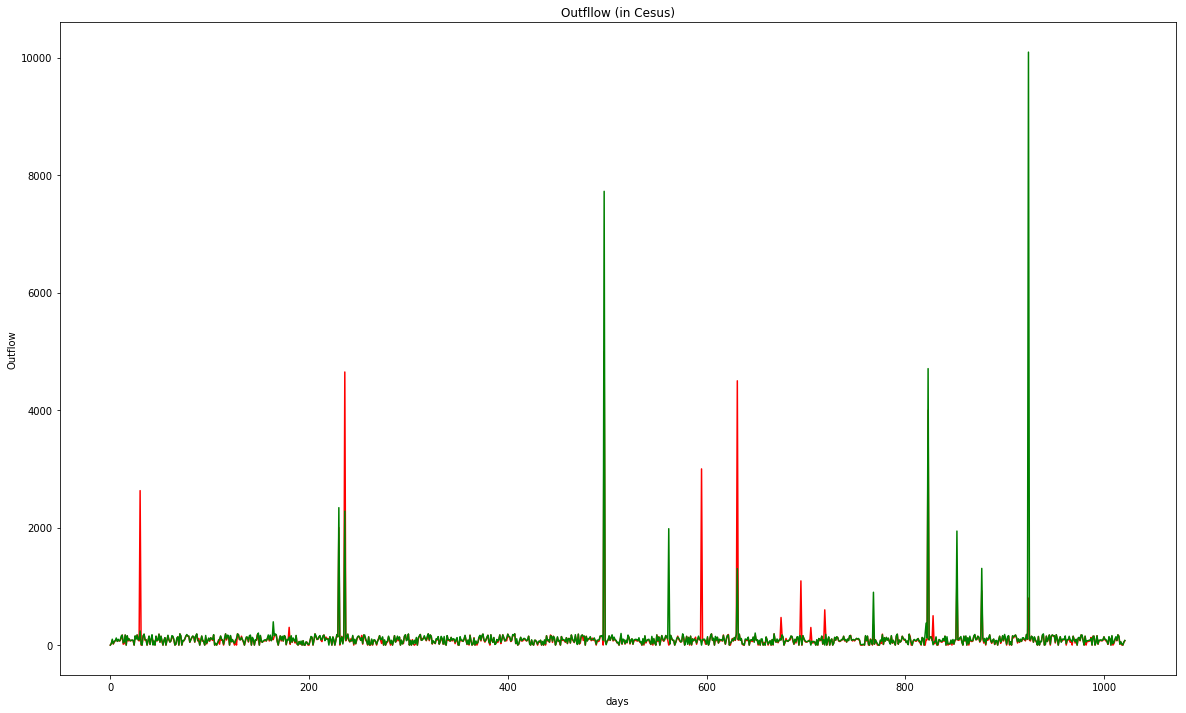

In [64]:
x=[]
for i in range(0,1022):
    x.append(i)
plt.figure(figsize=(20,12))
plt.plot(x,y_test[0], color= "red")
plt.plot(x, predictions[0], color = "green")
plt.title("Outfllow (in Cesus)")
plt.xlabel("days")
plt.ylabel("Outflow")
plt.show()

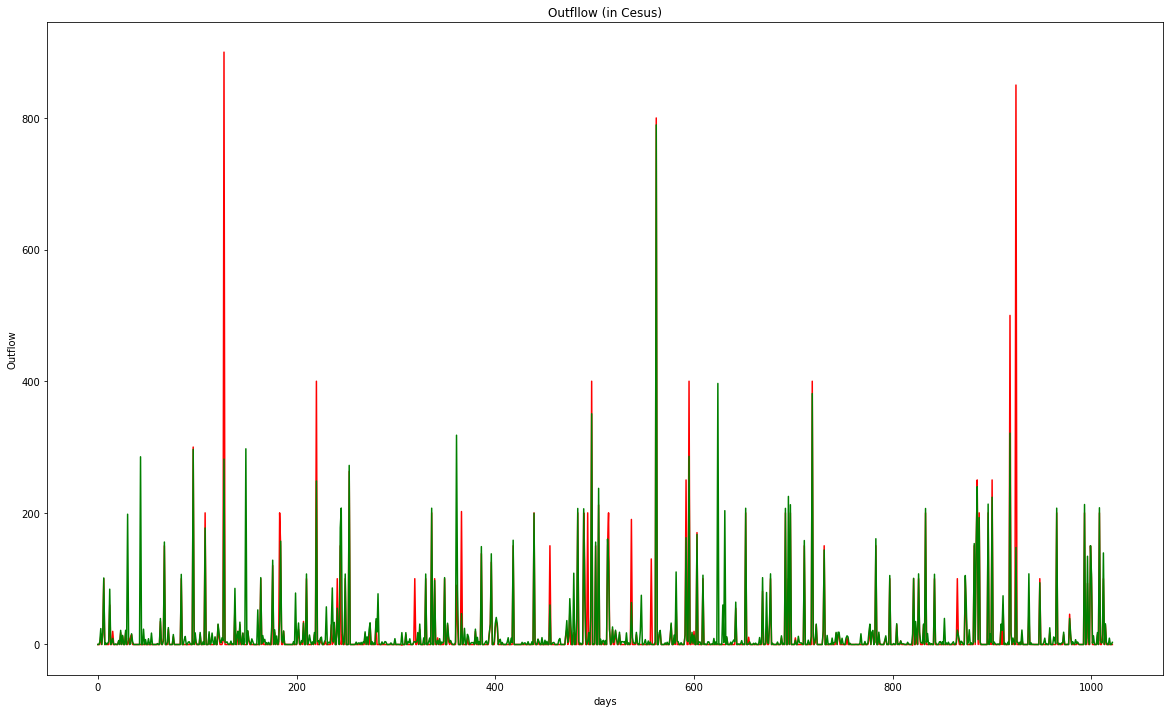

In [65]:
x=[]
for i in range(0,1022):
    x.append(i)
plt.figure(figsize=(20,12))
plt.plot(x,y_test[1], color= "red")
plt.plot(x, predictions[1], color = "green")
plt.title("Outfllow (in Cesus)")
plt.xlabel("days")
plt.ylabel("Outflow")
plt.show()

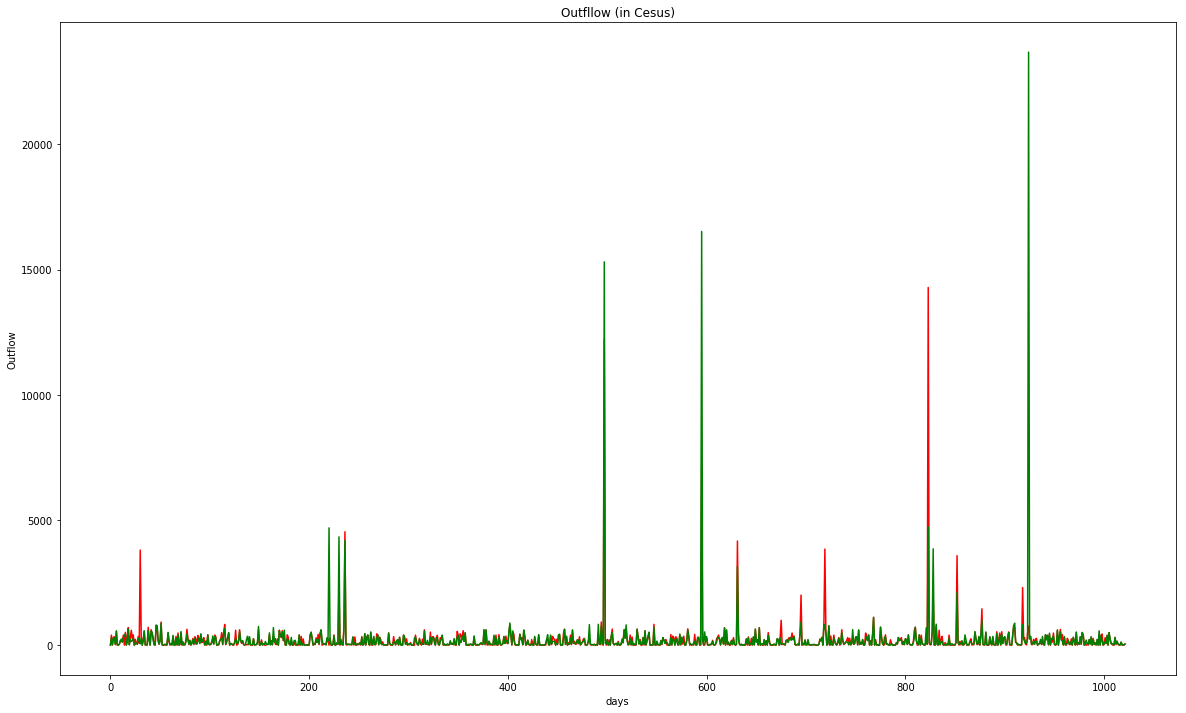

In [66]:
x=[]
for i in range(0,1022):
    x.append(i)
plt.figure(figsize=(20,12))
plt.plot(x,y_test[2], color= "red")
plt.plot(x, predictions[2], color = "green")
plt.title("Outfllow (in Cesus)")
plt.xlabel("days")
plt.ylabel("Outflow")
plt.show()

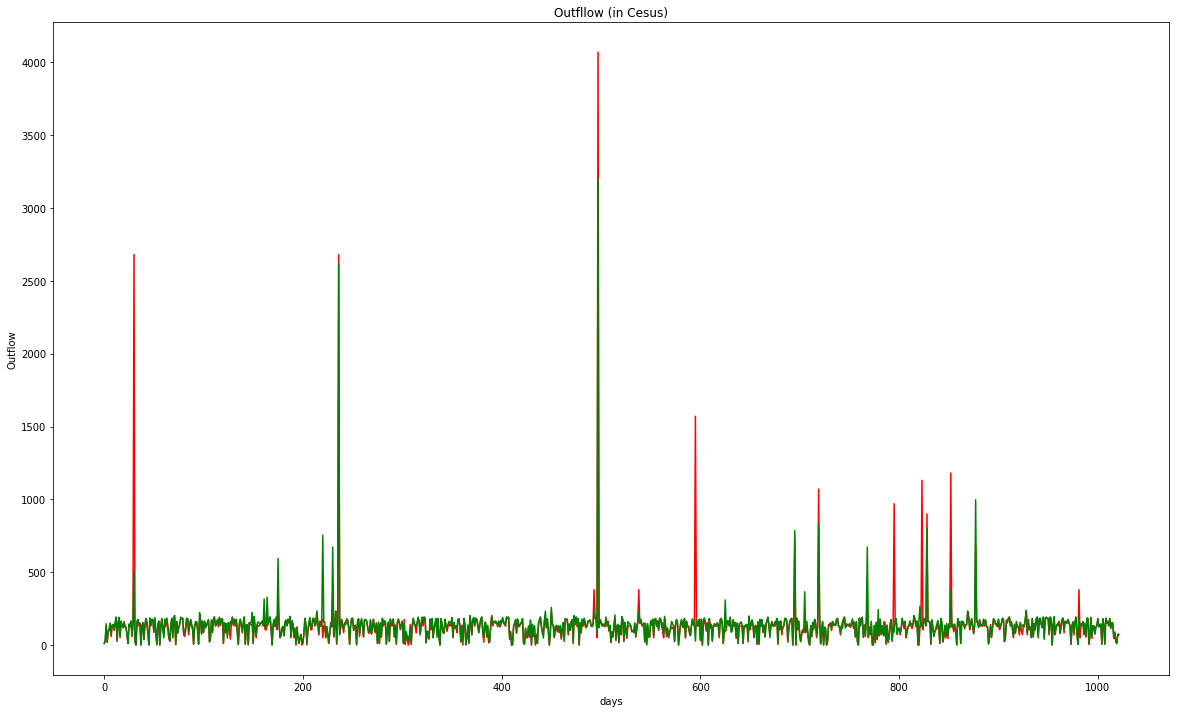

In [67]:
x=[]
for i in range(0,1022):
    x.append(i)
plt.figure(figsize=(20,12))
plt.plot(x,y_test[3], color= "red")
plt.plot(x, predictions[3], color = "green")
plt.title("Outfllow (in Cesus)")
plt.xlabel("days")
plt.ylabel("Outflow")
plt.show()

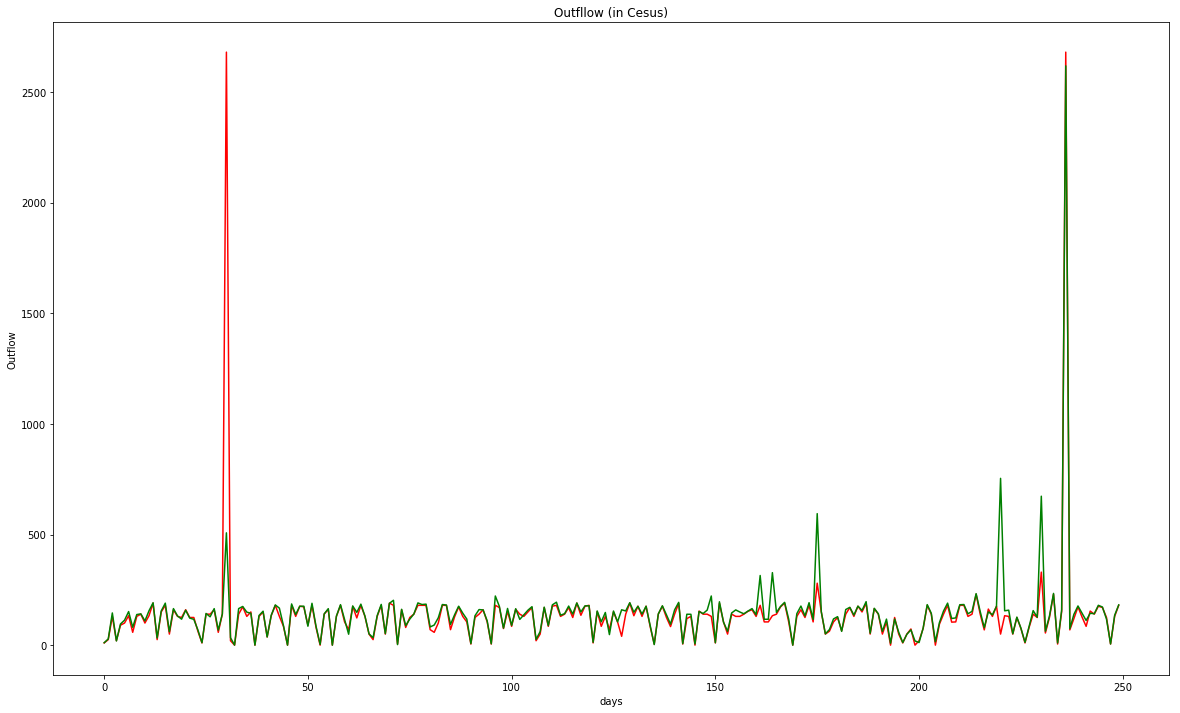

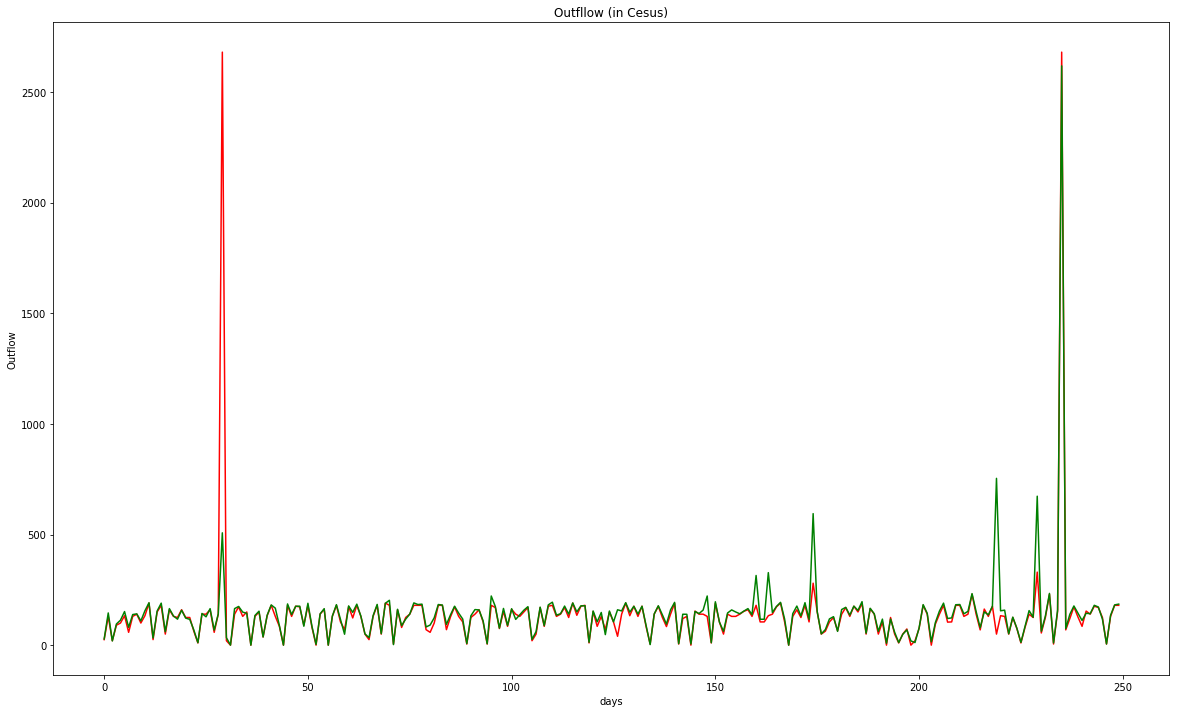

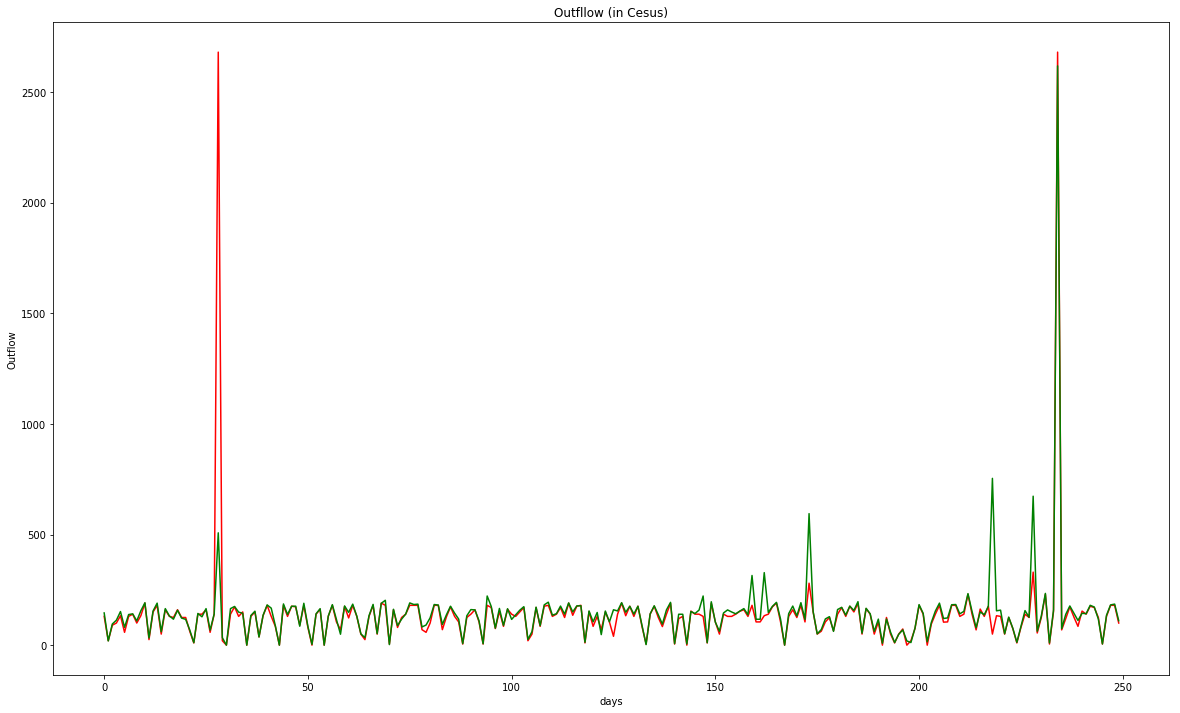

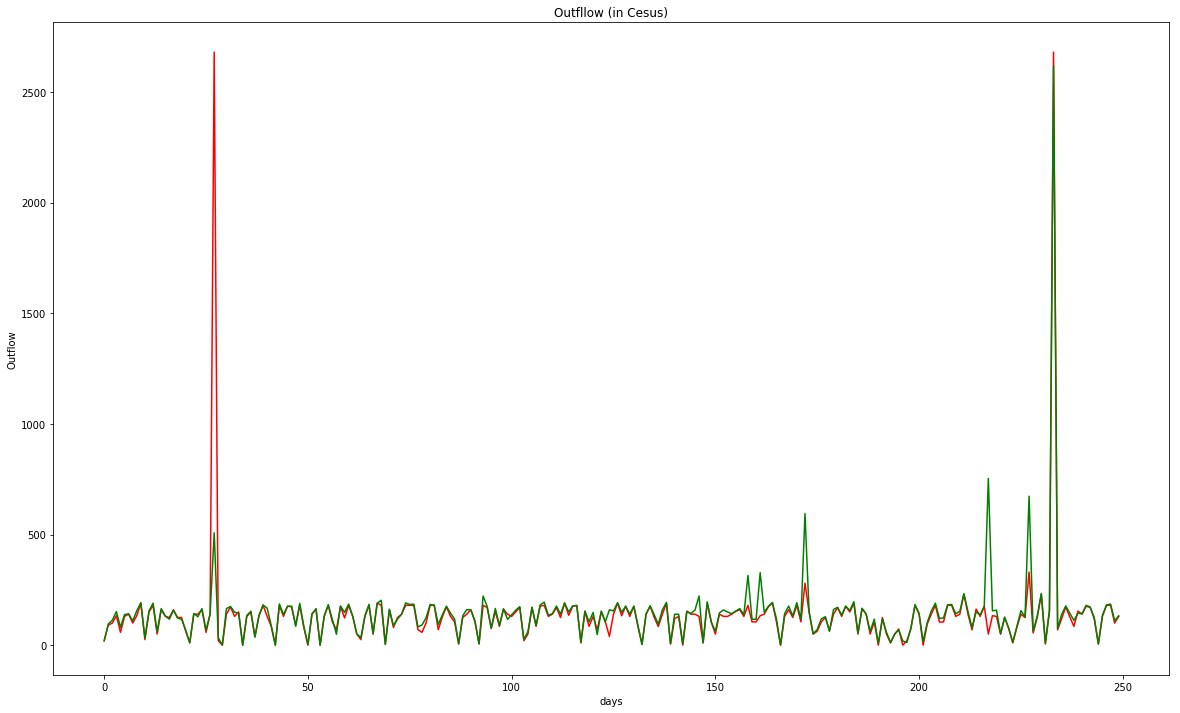

In [68]:
x=[]
for i in range(0,250):
    x.append(i)
y1=[]
y2=[]
for i in range(0,4):
    y1.append(predictions[3][i:i+250])
    y2.append(y_test[3][i:i+250])

for i in range(0,4):
    plt.figure(figsize=(20,12))
    plt.plot(x,y2[i], color= "red",label="original")
    plt.plot(x, y1[i], color = "green",label="predicted")
    plt.title("Outfllow (in Cesus)")
    plt.xlabel("days")
    plt.ylabel("Outflow")
    plt.show()